In [1]:
from binance.client import Client
import os
import pandas as pd
import statsmodels.api as sm
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
load_dotenv('api.env')
api_key = os.getenv("API_KEY")
api_secret = os.getenv("API_SECRET")
client = Client(api_key, api_secret)

In [2]:
def correct(df):
    df = df.copy()
    df = df[['open_time','open','high','low','close','volume']]
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms',utc=True)
    df['open_time'] = df['open_time'].dt.tz_convert('Europe/Istanbul')
    df.set_index('open_time',inplace=True)
    df = df.tz_localize(None)
    df[['open','high','low','close','volume']] = df[['open','high','low','close','volume']].apply(pd.to_numeric, errors='coerce')
    df = df.reset_index()
    df['time_index'] = (df['open_time'] - df['open_time'].min()).dt.total_seconds()
    return df

In [3]:
def create_model(df):
    X = sm.add_constant(df['time_index'])  
    y = df['close']

    model = sm.OLS(y, X).fit()
    return model

In [4]:
def get_predictions(df,model,alpha =0.1):
    X = sm.add_constant(df['time_index'])  
    predictions = model.get_prediction(X)  
    pred_summary = predictions.summary_frame(alpha=alpha)  
    return pred_summary

In [5]:
def draw(df,pred_summary,ticker):

    df['predicted'] = pred_summary['mean']
    df['lower_ci'] = pred_summary['obs_ci_lower']
    df['upper_ci'] = pred_summary['obs_ci_upper']

    plt.figure(figsize=(14, 6))
    plt.plot(df['open_time'], df['close'], label='Real Price', color='black', linewidth=1)
    plt.plot(df['open_time'], df['predicted'], label='Guess', color='blue', linestyle='--')
    plt.fill_between(df['open_time'], df['lower_ci'], df['upper_ci'], color='green', alpha=0.2, label='%90 Confidence interval')
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title(f"Lineer Regression guess for {ticker}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
def enhanced_draw(df, pred_summary, ticker,ci):

    df['predicted'] = pred_summary['mean']
    df['lower_ci'] = pred_summary['obs_ci_lower']
    df['upper_ci'] = pred_summary['obs_ci_upper']

    last_price = df['close'].iloc[-1]
    last_time = df['open_time'].iloc[-1]
    last_pred = df['predicted'].iloc[-1]
    last_upper = df['upper_ci'].iloc[-1]
    last_lower = df['lower_ci'].iloc[-1]

    plt.figure(figsize=(14, 6))
    plt.plot(df['open_time'], df['close'], label='Real Price', color='black', linewidth=1)
    plt.plot(df['open_time'], df['predicted'], label='Guess', color='blue', linestyle='--')
    plt.fill_between(df['open_time'], df['lower_ci'], df['upper_ci'], color='green', alpha=0.2, label=f'%{ci} Confidence interval')

    plt.text(last_time, last_pred, f' Guess: {last_pred:.6f}', color='blue', fontsize=10)
    plt.text(last_time, last_price, f' Last Price: {last_pred:.6f}', color='orange', fontsize=10)
    plt.text(last_time, last_upper, f' ↑ {last_upper:.6f}', color='green', fontsize=10)
    plt.text(last_time, last_lower, f' ↓ {last_lower:.6f}', color='red', fontsize=10)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=20))  
    plt.xticks(rotation=45)

    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title(f"Lineer Regression model {ticker}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
def runner():
    lister = ['BTCUSDT','ETHUSDT','BNBUSDT','SOLUSDT','XRPUSDT','DOGEUSDT','ADAUSDT','AVAXUSDT','LINKUSDT','DOTUSDT','TONUSDT','OPUSDT','ARBUSDT','SEIUSDT','WIFUSDT','APTUSDT','SUIUSDT']
    r_treshold = 0.7

    for ticker in lister:
        try:
            kline = client.futures_klines(symbol=ticker, interval=Client.KLINE_INTERVAL_1MINUTE, limit=300)
            df = pd.DataFrame(kline, columns=["open_time","open","high","low","close","volume","close_time","quote_asset_volume","num_trades","taker_buy_base","taker_buy_quote","ignore"])
            df = correct(df)
            model = create_model(df)
            preds1 = get_predictions(df,model,alpha=0.01)
            preds2 = get_predictions(df,model,alpha=0.0005)
            print(ticker,model.rsquared)
            if model.rsquared >r_treshold:
                enhanced_draw(df,pred_summary=preds1,ticker = ticker,ci=99)
                #enhanced_draw(df,pred_summary=preds2,ticker = ticker,ci=99.5)

        except Exception as e:
            print('Error:', e)

BTCUSDT 0.04652472809376096
ETHUSDT 0.0683115803382196
BNBUSDT 0.7754967625187114


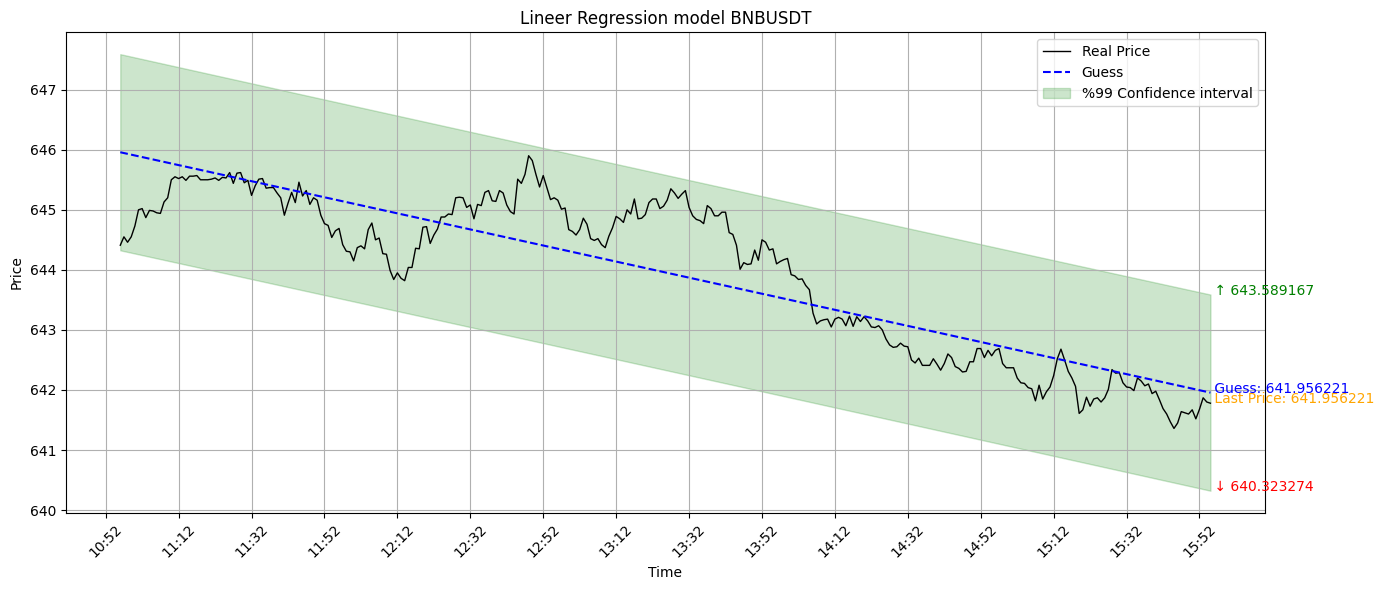

SOLUSDT 0.0936811439065075
XRPUSDT 0.35864534840510653
DOGEUSDT 0.6469078965773569
ADAUSDT 0.09265571966007402
AVAXUSDT 0.10027806261913297
LINKUSDT 0.020340608332090615
DOTUSDT 0.023162171577818413
TONUSDT 0.007193198968247105
OPUSDT 0.20352240569265123
ARBUSDT 0.3959071720715167
SEIUSDT 0.773420987071946


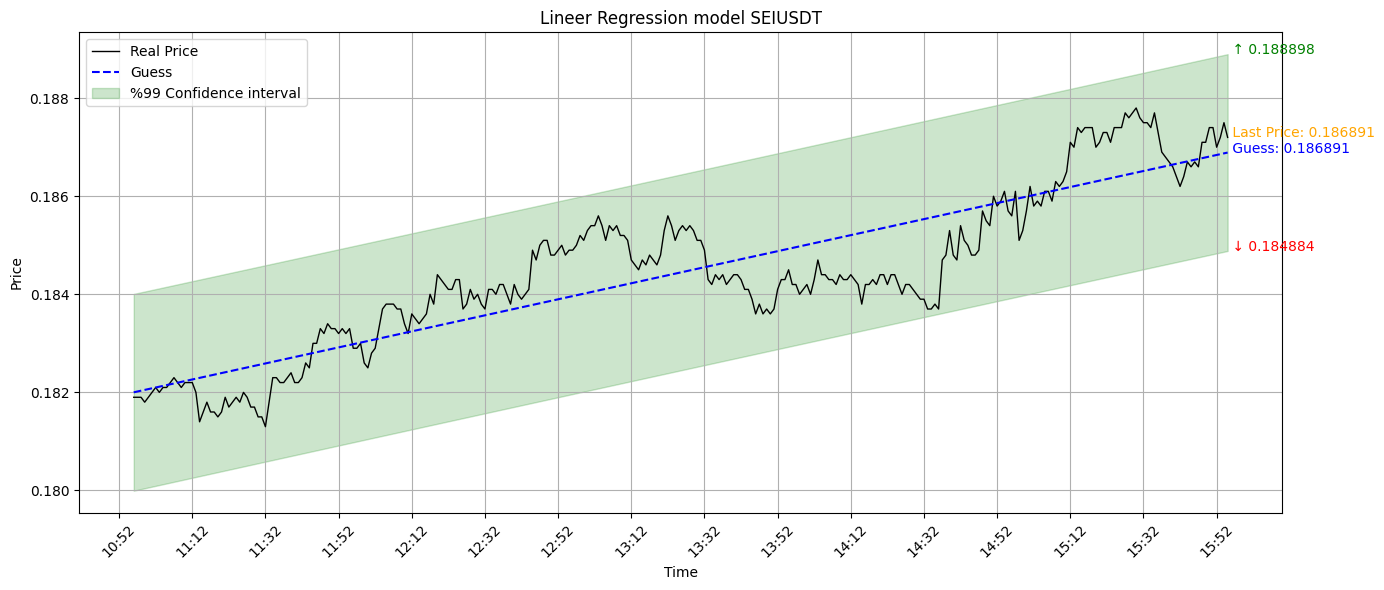

WIFUSDT 0.5940263307339169
APTUSDT 0.003419296806595473
SUIUSDT 0.11625208981055501
------------------------------------


KeyboardInterrupt: 

In [8]:
import time
if __name__ == "__main__":
    while True:
        start = time.time()
        runner()
        elapsed = time.time() - start
        to_sleep = max(0, 60 - elapsed)
        print('------------------------------------')
        time.sleep(to_sleep)